# The Music of the Sphere: Reconstruction tests from mock data and Planck posterior samples using SVD decomposition

*Laurence Perreault Levasseur, Phil Marshall, and Roger Blandford, January 2016*

In this notebook we generate a mock Universe and use the likelihood from Music allegro paper to reconstruct the 3D map of the interior sphere. We then proceed to reconstruct the 3D potential map from the 2D T map of a mock Universe generated from the independent Mathematica code. Finally, apply the reconstruction method to one of the samples of the Planck posterior, and display the most probable 3D map.

To do this we make use of 100 posterior sample Commander Planck CMB temperature maps to calculate the $a_{lm}$'s covariance matrix, and use a prior for the $f_n$'s constructed from a primordial power spectrum with amplitude given by Planck and a spectral index of 0.97. To do the reconstruction we do not use a mask on the T map and use SVD to deal with all ill-conditioned matrices.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import math
import beatbox
import os.path
import healpy as hp
%matplotlib inline

1


# Step 1: Using mock data generated by the multiverse beatbox

To run this section in a way that reproduces the figures displayed, it is important to change the values of the minimum and maxnimum $l$ and $n$ to
truncated\_nmax=2, truncated\_nmin=1, truncated\_lmax=8, truncated\_lmin=1 in the second line of the \_\_init\_\_.py file in the beatbox folder. This line instantiates the first multiverse, called beatbox.You

These values define the default class values (as well and the $\mathbf{R}$ matrix and the $k$ filter) for all the Universes created within this multiverse instance.

In [3]:
beatbox.You.create_original_Universe()
beatbox.You.initiate_simulated_universe()

Generated  32  potential Fourier coefficients
 with phases uniformly distributed between 0 and  3.14159265359
Built potential grid, with dimensions  (41, 41, 41)  and mean value  0.0 +/- 0.0002374


beatbox/universe.py:546: RuntimeWarning: divide by zero encountered in power
  self.Power_Spectrum = self.PSnorm*1000*np.power((self.k/self.kstar) ,(-3+(self.n_s-1)))


Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin


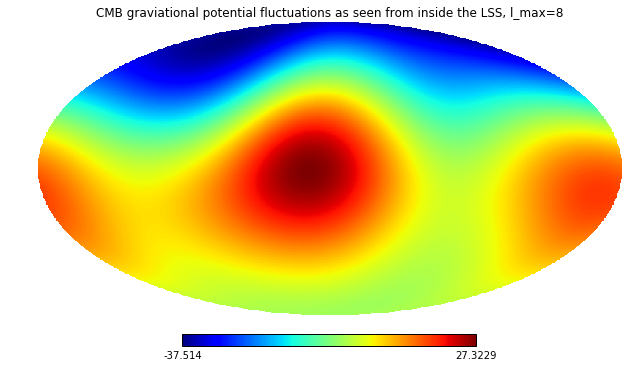

In [4]:
# Plot the generated T map
%matplotlib inline
import healpy as hp
beatbox.You.all_simulated_universes[-1].show_CMB_T_map(from_perspective_of="observer")

In [5]:
# Calculate C_yy from the 100 posterior sample Commander Planck CMB temperature maps 
#    or load the C_yy matrix if already calculated
if not os.path.isfile('data/covCyy_lmax8.txt'):
    beatbox.You.read_Planck_samples()
    beatbox.You.calculate_covariance_matrix(filename='covCyy_lmax8.txt')
else:
    beatbox.You.load_covariance_matrix(filename='covCyy_lmax8.txt')

In [6]:
# Calculate the inverse of the a_y covariance matrix
beatbox.You.calculate_sdv_Cyy_inverse()

Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin


beatbox/universe.py:383: ComplexWarning: Casting complex values to real discards the imaginary part
  ay_real[zero_ind] = value[zero_ind].astype(np.float)


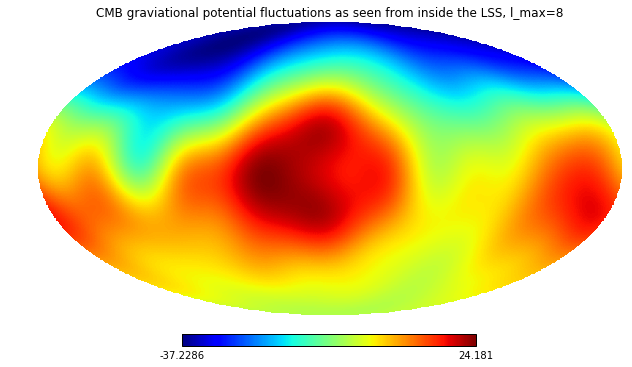

In [7]:
# Use the simulated Universe as mock data
# First, generate one realization of noise
noise = beatbox.You.generate_one_realization_of_noise()
# Add the noise to the realization of the sky map
datamap=beatbox.You.all_simulated_universes[-1].ay2ayreal_for_inference(beatbox.You.all_simulated_universes[-1].ay)+noise
datamap=datamap.T

# Plot the Mock Univers with the noise
MockUniverse=beatbox.Universe()
MockUniverse.ayreal2ay_for_mapping(datamap)
MockUniverse.ay2alm(MockUniverse.ay)
MockUniverse.show_CMB_T_map( from_perspective_of="observer")

In [8]:
# Reconstruct the potential
beatbox.You.solve_for_3D_potential(datamap)

beatbox/multiverse.py:286: ComplexWarning: Casting complex values to real discards the imaginary part
  R_real[zero_ind,:] = beatbox.Universe.R[zero_ind,:].astype(np.float)


Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin


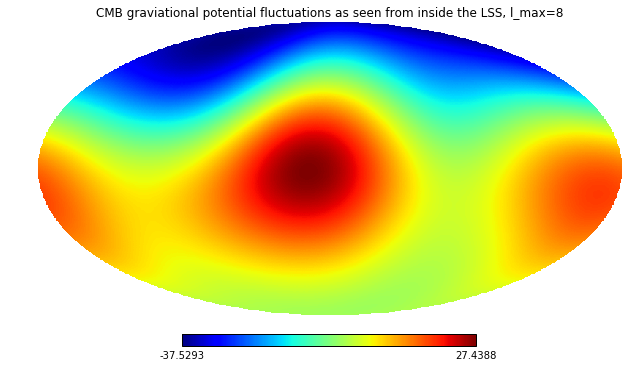

In [9]:
# Give those reconstructed f_n's to one realization of the Universe
We=beatbox.Universe()
We.fn=beatbox.You.reconstrunct_fn
We.transform_3D_potential_into_alm(truncated_nmax=We.truncated_nmax, truncated_nmin=We.truncated_nmin,truncated_lmax=We.truncated_lmax, truncated_lmin=We.truncated_lmin,usedefault=1, fn=1)
We.show_CMB_T_map(from_perspective_of="observer")

Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin


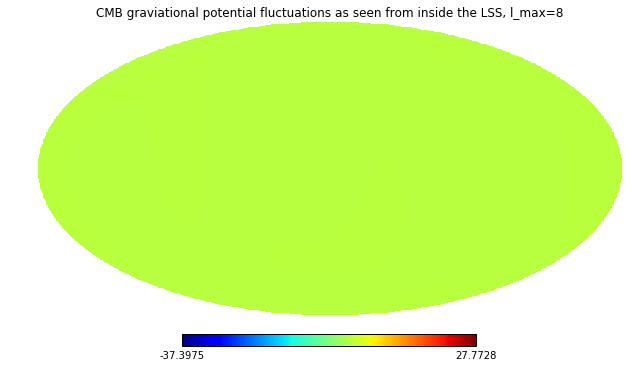

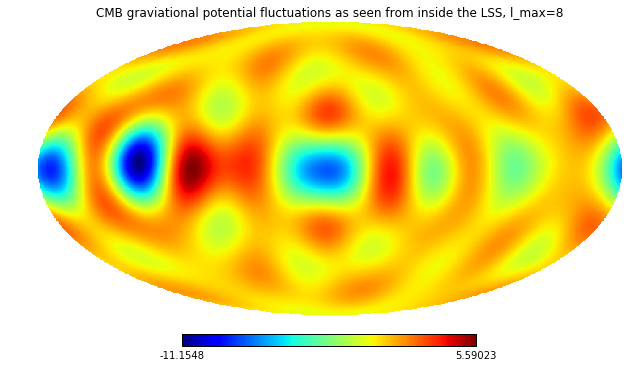

In [10]:
# Plot the residuals:
WeRes=beatbox.Universe()

WeRes.alm=(MockUniverse.alm-We.alm)

#WeRes.ay2alm(WeRes.ay)

hp.mollview(beatbox.You.all_simulated_universes[-1].Tmap-We.Tmap, min=-37.3975, max=27.7728, rot=(-90,0,0),title="CMB graviational potential fluctuations as seen from inside the LSS, l_max=%d" % We.truncated_lmax)

WeRes.show_CMB_T_map( from_perspective_of="observer")

# Look at the 3D reconstructed potential

In [11]:
# From those f_n's build the 3d spatial potential:
ind = np.where(We.kfilter>0)
NN = 2*len(ind[1])
k_x, k_y, k_z = We.kx[ind], We.ky[ind], We.kz[ind]


RealPhi = np.zeros(We.x.shape,dtype=np.complex128)
for i in range(len(k_x)/2):
    phase = k_x[i] * We.x + k_y[i] * We.y + k_z[i] * We.z
    RealPhi += (We.fn[i] * np.cos(phase)+We.fn[len(k_x)-1-i]*np.sin(phase))*We.Deltak**3
    We.phi = RealPhi.real

In [ ]:
import yt 
We.Pdist=1
We.Pmax=2*np.pi
We.show_potential_with_yt(angle=np.pi/8,  N_layer=6, cmap='BrBG', show3D=1, Slice=1)

In [35]:
# Plot the 3D volume rendering and the color map 
from IPython.core.display import Image
Image(url='Demo_figures/recons-lmax8-nmax2_phi3Ddomain.png',width=500)

In [39]:
# This is the colorbar, the only important piece is the gaussian bump
#    (still some work to be done on this...)
Image(url='Demo_figures/colormap-recons_only.png',width=400)

In [ ]:
We.show_potential_from_all_angles_with_yt('UNIVERSE-lmax8nmax2.gif')

In [15]:
Image(url='Demo_figures/UNIVERSE-lmax8nmax2.gif',width=500)

In [36]:
# Slice of the 3D potential at z=0:
Image(url='Demo_figures/phi-reconst_Slice_z-lmax8-nmax2.png',width=500)

### Now look at the residuals in the 3D volume

In [16]:
Weres2 = beatbox.Universe()
Weres2.fn = beatbox.You.all_simulated_universes[-1].fn.reshape(len(We.fn),1)-We.fn
ind = np.where(Weres2.kfilter>0)
NN = 2*len(ind[1])
k_x, k_y, k_z = Weres2.kx[ind], Weres2.ky[ind], Weres2.kz[ind]
RealPhi2 = np.zeros(We.x.shape,dtype=np.complex128)
for i in range(len(k_x)/2):
    phase2 = k_x[i] * Weres2.x + k_y[i] * Weres2.y + k_z[i] * Weres2.z
    RealPhi2 += (Weres2.fn[i] * np.cos(phase2)+Weres2.fn[len(k_x)-1-i]*np.sin(phase2))*Weres2.Deltak**3
    Weres2.phi = RealPhi2.real
Weres2.Pdist=1
Weres2.Pmax=2*np.pi

In [ ]:
Weres2.show_potential_with_yt(angle=np.pi/8,  N_layer=6, cmap='BrBG', show3D=1, Slice=0)

In [28]:
Image(url='Demo_figures/res-lmax8-nmax2_phi3Ddomain.png',width=500)

In [40]:
# Slice of the 3D potential at z=0:
Image(url='Demo_figures/phi-res_Slice_z-lmax8-nmax2.png',width=500)

Looking at these residuals in 3D, looks like here we can reconstruct the true potential in the interior of the sphere within $10\%$ from the most probable values of $f_n$, when $l_{max}=8$ and $n_{max}=2$

# Step 2: Using mock data generated by Roger

To run this section, it is important to 1) restart the kernel if step 1 was run and then re-run the first 2 cells of this file and 2) change the values of the minimum and maxnimum $l$ and $n$ to
truncated\_nmax=3, truncated\_nmin=1, truncated\_lmax=8, truncated\_lmin=1 in the second line of the \_\_init\_\_.py file in the beatbox folder. This line instantiates the first multiverse, called beatbox.You

These values define the default class values (as well and the $\mathbf{R}$ matrix and the $k$ filter) for all the Universes created within this multiverse instance.

In [3]:
beatbox.You.create_original_Universe()
beatbox.You.initiate_simulated_universe()

Generated  122  potential Fourier coefficients
 with phases uniformly distributed between 0 and  3.14159265359
Built potential grid, with dimensions  (41, 41, 41)  and mean value  0.0 +/- 0.0002829


beatbox/universe.py:546: RuntimeWarning: divide by zero encountered in power
  self.Power_Spectrum = self.PSnorm*1000*np.power((self.k/self.kstar) ,(-3+(self.n_s-1)))


Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin


beatbox/universe.py:383: ComplexWarning: Casting complex values to real discards the imaginary part
  ay_real[zero_ind] = value[zero_ind].astype(np.float)


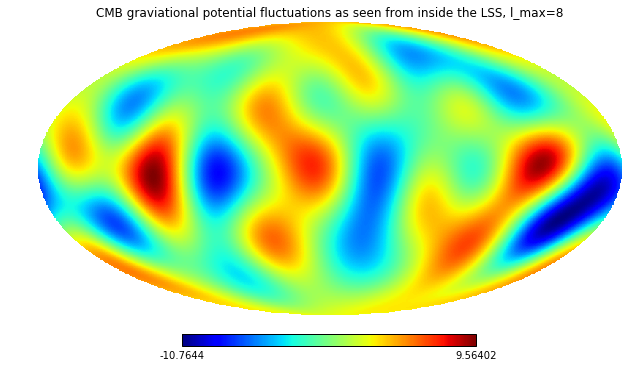

In [4]:
# Import and display the data generated by Roger's Mathematica code is a data Universe
beatbox.You.all_data_universes = np.append(beatbox.You.all_data_universes, beatbox.Universe())
beatbox.You.all_data_universes[-1].ay = np.loadtxt("data/Rogersay.txt").view(complex)
beatbox.You.all_data_universes[-1].ay2alm(beatbox.You.all_data_universes[-1].ay,truncated_lmax=8, truncated_lmin=1, usedefault=0)
beatbox.You.all_data_universes[-1].show_CMB_T_map(from_perspective_of="observer")

# Assign the a_lm values to be the data to reconstruct
datamap = beatbox.You.all_data_universes[-1].ay2ayreal_for_inference(beatbox.You.all_data_universes[-1].ay)

Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin


beatbox/multiverse.py:286: ComplexWarning: Casting complex values to real discards the imaginary part
  R_real[zero_ind,:] = beatbox.Universe.R[zero_ind,:].astype(np.float)


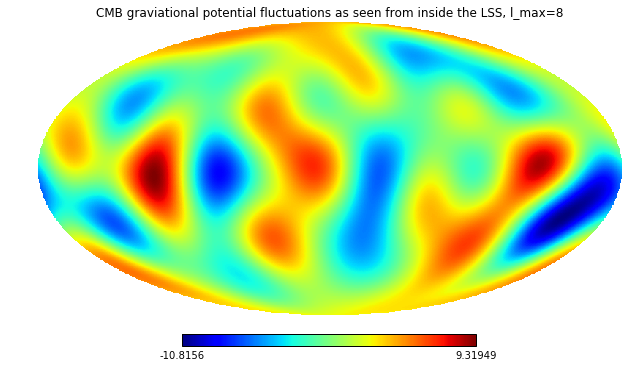

In [21]:
# Calculate C_yy from the 100 posterior sample Commander Planck CMB temperature maps 
#    or load the C_yy matrix if already calculated
if not os.path.isfile('data/covCyy_lmax8.txt'):
    beatbox.You.read_Planck_samples()
    beatbox.You.calculate_covariance_matrix(filename='lmax8')
else:
    beatbox.You.load_covariance_matrix(filename='covCyy_lmax8.txt')
    
# Calculate the inverse of the a_y covariance matrix
beatbox.You.calculate_sdv_Cyy_inverse()

# Reconstruct the potential
beatbox.You.solve_for_3D_potential(datamap)


# Give those reconstructed f_n's to one realization of the Universe
We = beatbox.Universe()
We.fn = beatbox.You.reconstrunct_fn
#We.fn = beatbox.You.all_simulated_universes[-1].fn * 0.5
We.transform_3D_potential_into_alm(truncated_nmax=We.truncated_nmax, truncated_nmin=We.truncated_nmin,truncated_lmax=We.truncated_lmax, truncated_lmin=We.truncated_lmin,usedefault=1, fn=1)
We.show_CMB_T_map(from_perspective_of="observer")


Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin


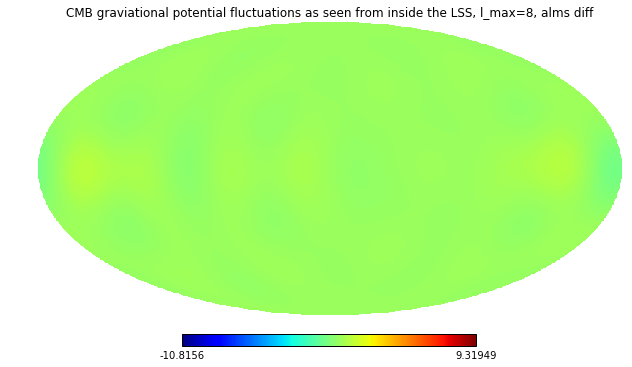

In [22]:
# residuals of the Tmap:
WeRes = beatbox.Universe()
WeRes.alm = (beatbox.You.all_data_universes[-1].alm-We.alm)

#WeRes.ay2alm(WeRes.ay)
WeRes.NSIDE = 256
WeRes.Tmap = hp.alm2map(WeRes.alm,WeRes.NSIDE)

hp.mollview(WeRes.Tmap,  rot=(-90,0,0), min=-10.8156, max=9.31949, title="CMB graviational potential fluctuations as seen from inside the LSS, l_max=%d, alms diff" % We.truncated_lmax)

# Step 3: Using 'real' data from Planck posterior samples 

To run this section, it is important to 1) restart the kernel if step 1 or 2 was run and then re-run the first 2 cells of this file and 2) change the values of the minimum and maxnimum $l$ and $n$ to
truncated\_nmax=3, truncated\_nmin=1, truncated\_lmax=10, truncated\_lmin=1 in the second line of the \_\_init\_\_.py file in the beatbox folder. This line instantiates the first multiverse, called beatbox.You

These values define the default class values (as well and the $\mathbf{R}$ matrix and the $k$ filter) for all the Universes created within this multiverse instance.

In [3]:
beatbox.You.create_original_Universe()
beatbox.You.initiate_simulated_universe()

Generated  122  potential Fourier coefficients
 with phases uniformly distributed between 0 and  3.14159265359
Built potential grid, with dimensions  (41, 41, 41)  and mean value  0.0 +/- 0.0002829


beatbox/universe.py:546: RuntimeWarning: divide by zero encountered in power
  self.Power_Spectrum = self.PSnorm*1000*np.power((self.k/self.kstar) ,(-3+(self.n_s-1)))


NSIDE = 256
ORDERING = RING in fits file
INDXSCHM = IMPLICIT
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin


beatbox/universe.py:383: ComplexWarning: Casting complex values to real discards the imaginary part
  ay_real[zero_ind] = value[zero_ind].astype(np.float)


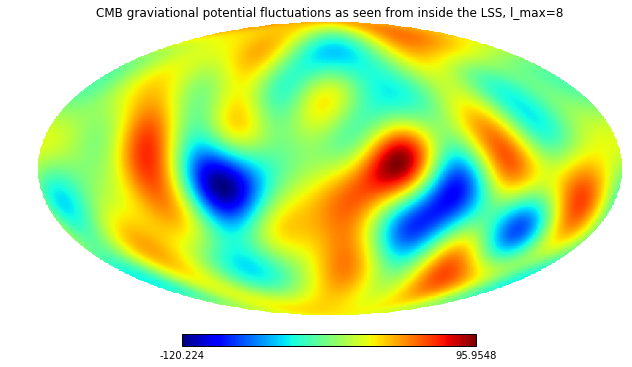

In [4]:
# Import the data from one of the Planck posterior samples
beatbox.You.all_data_universes = np.append(beatbox.You.all_data_universes, beatbox.Universe())
beatbox.You.all_data_universes[-1].read_in_CMB_T_map(from_this='data/commander_32band_Clsamples100/cmb_Cl_c0001_k00030.fits')
beatbox.You.all_data_universes[-1].decompose_T_map_into_spherical_harmonics()
beatbox.You.all_data_universes[-1].alm2ay()
beatbox.You.all_data_universes[-1].ay2alm(beatbox.You.all_data_universes[-1].ay)
# Assign the a_lm values to be the data to reconstruct
datamap = beatbox.You.all_data_universes[-1].ay2ayreal_for_inference(beatbox.You.all_data_universes[-1].ay)

# Plot the generated T map
beatbox.You.all_data_universes[-1].show_CMB_T_map(from_perspective_of="observer")

0.00855857960046
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin


beatbox/multiverse.py:286: ComplexWarning: Casting complex values to real discards the imaginary part
  R_real[zero_ind,:] = beatbox.Universe.R[zero_ind,:].astype(np.float)


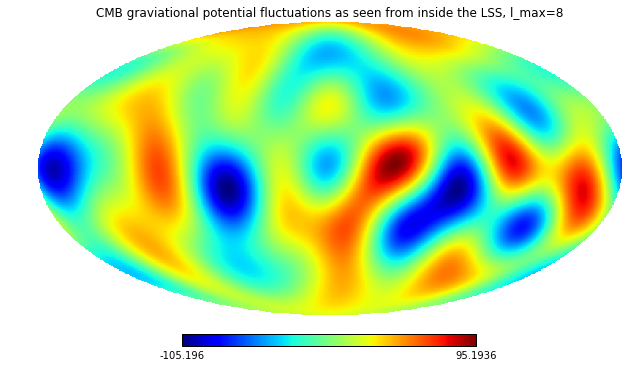

In [5]:
if not os.path.isfile('data/covCyy_lmax8.txt'):
    beatbox.You.read_Planck_samples()
    beatbox.You.calculate_covariance_matrix(filename='lmax8')
else:
    beatbox.You.load_covariance_matrix(filename='covCyy_lmax8.txt')
    
# Calculate the inverse of the a_y covariance matrix
beatbox.You.calculate_sdv_Cyy_inverse()

# Reconstruct the potential
beatbox.You.solve_for_3D_potential(datamap)


# Give those reconstructed f_n's to one realization of the Universe
We = beatbox.Universe()
We.fn = beatbox.You.reconstrunct_fn
We.transform_3D_potential_into_alm(truncated_nmax=We.truncated_nmax, truncated_nmin=We.truncated_nmin,truncated_lmax=We.truncated_lmax, truncated_lmin=We.truncated_lmin,usedefault=1, fn=1)
We.show_CMB_T_map(from_perspective_of="observer")

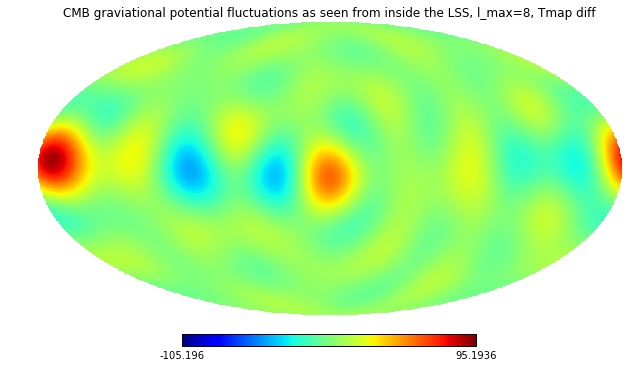

In [8]:
# Plot the residuals:
hp.mollview(beatbox.You.all_data_universes[-1].Tmap-We.Tmap, min=-105.196, max=95.1936,  rot=(-90,0,0),title="CMB graviational potential fluctuations as seen from inside the LSS, l_max=%d, Tmap diff" % We.truncated_lmax)

In [13]:
# From those f_n's build the 3d spatial potential:
ind = np.where(We.kfilter>0)
NN = 2*len(ind[1])
k_x, k_y, k_z = We.kx[ind], We.ky[ind], We.kz[ind]


RealPhi = np.zeros(We.x.shape,dtype=np.complex128)
for i in range(len(k_x)/2):
    phase = k_x[i] * We.x + k_y[i] * We.y + k_z[i] * We.z
    RealPhi += (We.fn[i] * np.cos(phase)+We.fn[len(k_x)-1-i]*np.sin(phase))*We.Deltak**3
    We.phi = RealPhi.real

In [ ]:
We.Pdist=1
We.Pmax=2*np.pi
We.show_potential_from_all_angles_with_yt(output='REAL-UNIV_recon.gif')

In [ ]:
We.show_potential_with_yt(angle=np.pi/8,alpha_norm=5,  N_layer=5, cmap='BrBG', show3D=1, Slice=0)

In [115]:
from IPython.core.display import Image
Image(url='Demo_figures/recons-lmax8-nmax3_phi3Ddomain2.png',width=500)

In [117]:
Image(url='Demo_figures/REAL-UNIV_recon-lmax8-nmax3.gif',width=500)

In [118]:
Image(url='Demo_figures/phi_realuniv-reconst_Slice_z-lmax8-nmax3.png',width=500)